In [1]:
import torch
import torchvision
import h5py
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL.Image
import PoolTileNet
from fastai import *
from fastai.vision import *
from sklearn.model_selection import StratifiedKFold

# TRAIN = "/home/zhaoxun/codes/Panda/_data/iafoss/train"
# LABELS = '/home/zhaoxun/codes/Panda/_data/train.csv'


class PngData(object):
    def __init__(self, TRAIN = "/home/zhaoxun/codes/Panda/_data/iafoss/train", LABELS = '/home/zhaoxun/codes/Panda/_data/train.csv', N = 12, size = 128):
        self.TRAIN = TRAIN
        self.mean = torch.tensor([1.0 - 0.90949707, 1.0 - 0.8188697, 1.0 - 0.87795304])[..., None, None]
        self.std = torch.tensor([0.36357649, 0.49984502, 0.40477625])[..., None, None]
        self.sz = size
        self.N = N

        nfolds = 5
        df = pd.read_csv(LABELS).set_index('image_id')
        files = sorted(set([p[:32] for p in os.listdir(TRAIN)]))
        df = df.loc[files]
        df = df.reset_index()
        splits = StratifiedKFold(n_splits = nfolds, random_state =1, shuffle =True)
        splits = list(splits.split(df, df.isup_grade))
        folds_splits = np.zeros(len(df)).astype(np.int)
        for i in range(nfolds):
            folds_splits[splits[i][1]] = i
        df['split'] = folds_splits
        self.df = df

    @classmethod
    def open_image(cls, fn, div = True, convert_mode = 'RGB', imcls = Image, after_open = None):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", UserWarning)
            x = PIL.Image.open(fn).convert(convert_mode)
        if after_open:
            x = after_open(x)
        x = pil2tensor(x, np.float32)
        if div: x.div_(255)
        return imcls(1.0 - x)

    @property
    def MyImage(self):
        outter = self
        class _MyImage(ItemBase):
            def __init__(self, imgs):
                self.obj = (imgs)
                self.data = [(img.data - outter.mean) / outter.std for img in imgs]

            def __repr__(self): 
                return f'{self.__class__.__name__} {[img.shape for img in self.obj]}'

            def apply_tfms(self, tfms, *args, **kwargs):
                for i in range(len(self.obj)):
                    self.obj[i] = self.obj[i].apply_tfms(tfms, *args, **kwargs)
                    self.data[i] = (self.obj[i].data - outter.mean) / outter.std
                return self

            def to_one(self):
                img = torch.stack(self.data, 1)
                img = (img
                    .view(3, -1, outter.N, outter.sz, outter.sz)
                    .permute(0, 1, 3, 2, 4)
                    .contiguous()
                    .view(3, -1, outter.sz, outter.N))
                return Image(1.0 - (outter.mean + img * outter.std))
        return _MyImage

    @property
    def MyImageItemList(self):
        outter = self
        class _MyImageItemList(ImageList):
            def __init__(self, *args, **kwargs):
                super().__init__(*args, **kwargs)

            def __len__(self): 
                return len(self.items) or 1

            def get(self, i):
                fn = Path(self.items[i])
                fnames = [Path("%s_%d.png" % (fn, i)) for i in range(outter.N)]
                imgs = [outter.open_image(fname, convert_mode = self.convert_mode, after_open = self.after_open) for fname in fnames]
                return outter.MyImage(imgs)

            def reconstruct(self, t):
                return outter.MyImage([outter.mean + ti * outter.std for ti in t])

            def show_xys(self, xs, ys, figsize = (300, 50), **kwargs):
                rows = min(len(xs), 8)
                fig, axs = plt.subplots(rows, 1, figsize = figsize)
                for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
                    xs[i].to_one().show(ax = ax, y = ys[i], **kwargs)
                plt.tight_layout()
        return _MyImageItemList

    # collate function to combine multiple images into one tensor
    def MImage_collate(self, batch) -> Tensor:
        result = torch.utils.data.dataloader.default_collate(to_data(batch))
        if isinstance(result[0], list):
            result = [torch.stack(result[0], 1), result[1]]
        return result

    def get_data(self, bs, bg = None, br = 0.8):
        trainidx = self.df.index[self.df.split != 0].tolist()
        if bg is not None: trainidx = np.random.choice(trainidx, round(len(trainidx) * br), replace = False)
        validx = self.df.index[self.df.split == 0].tolist()
        return (self.MyImageItemList.from_df(self.df, path = '/', folder = self.TRAIN, cols = 'image_id')
                .split_by_idxs(trainidx, validx)
                .label_from_df(cols = ['isup_grade'])
                .transform(get_transforms(flip_vert = True, max_rotate = 15), size = self.sz, padding_mode = 'zeros')
                .databunch(bs = bs, num_workers = 4))




Bad key "text.kerning_factor" on line 4 in
/data/zhaoxun/miniconda3/envs/torch/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
class Train(object):
    def __init__(self, **kwargs):
        self.kwargs = kwargs
        self.data = PngData()

        # model
        self.load_net()

        # loss
        if kwargs['ls'] == "focal":
            self.loss = PoolTileNet.FocalSmoothLoss(kwargs['nc'], kwargs['sm'], kwargs['gm'])
        elif kwargs['ls'] == "cross":
            self.loss = torch.nn.CrossEntropyLoss()
        
        if kwargs['op'] == "sgd":
            self.opt = torch.optim.SGD
        elif kwargs['op'] == "adam":
            self.opt = RAdam
        elif kwargs['op'] == "over":
            self.opt = Over9000

    def load_net(self):
        if self.kwargs['nt'] == "resnet34":
            self.net = PoolTileNet.PoolTileNetList(self.kwargs["nc"])
        elif self.kwargs['nt'] == "resnext50":
            self.net = PoolTileNet.SemiResNextList(n = self.kwargs['nc'])
        elif self.kwargs['nt'] == "eff":
            self.net = PoolTileNet.MyEfficientNet(self.kwargs['nc'])
        self.net = self.net.cuda()
        if self.kwargs['MD']:
            dic = torch.load(self.kwargs['MD'])
            self.net.load_state_dict(dic)

    def callback_bak(self, i, loss, valloader):
        self.losses["train"].append(loss)
        self.net.eval()
        with torch.no_grad():
            valloss = 0; valcnt = 0
            for x, y in tqdm.tqdm(valloader, desc = "Validating...", leave = False, mininterval = 60):
                x = x.cuda(); y = y.cuda()
                yhat = self.net(x)
                cost = self.loss(yhat, y.long())
                valloss += cost.item() * len(x); valcnt += len(x)
            self.losses["val"].append(valloss / valcnt)
        printOut("{:3d} | tr: {:.3f} | vl: {:.3f}".format(i, loss, valloss / valcnt))
        return valloss / valcnt

    class callback(LearnerCallback):
        def __init__(self, ln):
            self.ln = ln
            self.losses = {"train": [], "val": []}
            

        @property
        def header(self):
            return self.ln.recorder.names

        def on_epoch_end(self, epoch, smooth_loss, last_metrics, **kwargs):
            self.losses['train'].append(float(smooth_loss))
            self.losses['val'].append(float(last_metrics[0]))
            self.write_stats([epoch, smooth_loss] + last_metrics)

        def write_stats(self, stats):
            printOut("{:3d} | tr: {:.3f} | vl: {:.3f} | kp: {:.3f}".format(*stats))

        def on_train_end(self, **kwargs):
            plt.plot(self.losses['train'], label = "train")
            plt.plot(self.losses['val'], label = "val")
            plt.legend()
            plt.savefig(plotpath)

    def evaluations_bak(self, trainloader, valloader):
        K = self.kwargs['nc']
        with torch.no_grad():
            self.net.eval()
            for i, loader in enumerate((trainloader, valloader)):
                Y = np.zeros(len(loader.dataset), dtype = np.int); Yhat = np.zeros(len(loader.dataset), dtype = np.int); idx = 0
                for x, y in tqdm.tqdm(loader, desc = "Evaluating...", leave = False, mininterval = 60):
                    x = x.cuda(); y = y.numpy()
                    yhat = self.net(x).argmax(1).cpu().data.numpy()
                    Y[idx:idx + len(y)] = y; Yhat[idx:idx + len(y)] = yhat; idx += len(y)
                printOut(["Train", "Val"][i] + " kappa: %.4f" % (metrics.cohen_kappa_score(Y, Yhat, weights = "quadratic")))
                printOut(["Train", "Val"][i] + ":\n" + str(metrics.confusion_matrix(Y, Yhat)))
                printOut("\n~~~~~\n")
        plt.plot(self.losses['train'], label = "train")
        plt.plot(self.losses['val'], label = "val")
        plt.legend()
        plt.savefig(plotpath)

    def evaluations(self, ln):
        pred,target = [],[]
        ln.model.eval()
        with torch.no_grad():
            for step, (x, y) in progress_bar(enumerate(ln.data.dl(DatasetType.Valid)), total=len(ln.data.dl(DatasetType.Valid))):
                p = ln.model(*x)
                pred.append(p.float().cpu())
                target.append(y.cpu())
        p = torch.argmax(torch.cat(pred, 0), 1)
        t = torch.cat(target)
        printOut("Val kappa: %.5f" % cohen_kappa_score(t, p, weights = 'quadratic'))
        printOut(confusion_matrix(t, p))

    def bag_eval(self):
        pred,target = [],[]
        dirpath = modelpath + "s"
        dl = self.data.get_data(self.kwargs['bs'], 0, self.kwargs['br'])
        for bag in range(self.kwargs['bg']):
            self.net.load_state_dict(torch.load(os.path.join(dirpath, "model.%d.pth" % bag)))
            ln = Learner(dl, self.net, loss_func = self.loss, opt_func = self.opt, metrics = [KappaScore(weights = 'quadratic')], bn_wd = False, wd = self.kwargs['wd']).to_fp16()
            ln.model.eval()
            with torch.no_grad():
                for step, (x, y) in progress_bar(enumerate(ln.data.dl(DatasetType.Valid)), total=len(ln.data.dl(DatasetType.Valid))):
                    p = ln.model(*x)
                    if len(pred) == step: 
                        pred.append(p.float().cpu())
                        target.append(y.cpu())
                    else:
                        pred[step] += p.float().cpu()
        p = torch.argmax(torch.cat(pred, 0), 1)
        t = torch.cat(target)
        printOut("Val kappa: %.5f" % cohen_kappa_score(t, p, weights = 'quadratic'))
        printOut(confusion_matrix(t, p))

    def train_bak(self):
        trainloader, valloader = self.data.toLoader(self.kwargs['bs'])
        for i in tqdm.tqdm(range(1, self.kwargs['ep'] + 1), desc = "Iterating...", mininterval = 60):
            self.net.train()    
            loss = 0; cnt = 0
            for x, y in tqdm.tqdm(trainloader, desc = "Training...", leave = False, mininterval = 60):
                x = x.cuda(); y = y.cuda()
                yhat = self.net(x)
                cost = self.loss(yhat, y.long())
                loss += cost.item() * len(x); cnt += len(x)
                self.opt.zero_grad()
                cost.backward()
                self.opt.step()
            valloss = self.callback(i, loss / cnt, valloader)
            self.sch.step(valloss)
        torch.save(self.net.state_dict(), modelpath)
        self.evaluations(trainloader, valloader)

    def train(self, dl = None):
        dl = self.data.toLoader(self.kwargs['bs']) if dl is None else dl
        ln = Learner(dl, self.net, loss_func = self.loss, opt_func = self.opt, metrics = [KappaScore(weights = 'quadratic')], bn_wd = False, wd = self.kwargs['wd']).to_fp16()
        ln.clip_grad = 1.0
        ln.split([self.net.head])
        ln.unfreeze()
        cb = self.callback(ln)
        ln.fit_one_cycle(self.kwargs['ep'], max_lr = self.kwargs['lr'], div_factor = self.kwargs['df'], pct_start = 0.0, wd = self.kwargs['wd'], callbacks = [cb])
        torch.save(self.net.state_dict(), modelpath)
        self.evaluations(ln)

    def bag_train(self):
        dirpath = modelpath + "s"
        os.system("mkdir -p %s" % dirpath)
        for bag in range(self.kwargs['bg']):
            dl = self.data.get_data(self.kwargs['bs'], bag, self.kwargs['br'])
            self.load_net()
            self.train(dl)
            os.system("mv %s %s" % (modelpath, os.path.join(dirpath, "model.%d.pth" % bag)))
        self.bag_eval()



In [3]:
import argparse
def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("-f", "--h5", help = "h5 file path", default = "/home/zhaoxun/codes/Panda/_data/v0.h5", type = str)
    parser.add_argument("-M", "--MD", help = "model file", default = "", type = str)
    parser.add_argument("-N", "--nt", help = "net type", default = "resnet34", choices = ["resnet34", "resnext50", "eff"], type = str)
    parser.add_argument("-e", "--ep", help = "number of epochs", default = 5, type = int)
    parser.add_argument("-n", "--nc", help = "number of classes", default = 6, type = int)
    # parser.add_argument("-p", "--pt", help = "pretrained", default = True, type = bool)
    parser.add_argument("-l", "--lr", help = "learning rate", default = 1e-3, type = float)
    parser.add_argument("-L", "--ls", help = "loss type", default = "cross", choices = ["cross", "focal"], type = str)
    parser.add_argument("-b", "--bs", help = "batch size", default = 32, type = int)
    # parser.add_argument("-c", "--cb", help = "call-back step size", default = 1, type = int)
    # parser.add_argument("-s", "--ss", help = "learning rate scheduler step size", default = 30, type = int)
    parser.add_argument("-w", "--wd", help = "weight decay", default = 1e-3, type = float)
    # parser.add_argument("-g", "--gp", help = "gpus", default = [0], type = list)
    parser.add_argument("-d", "--dv", help = "visible devices", default = "3", choices = list("0123"), type = str)
    parser.add_argument("-s", "--sm", help = "label smoothing", default = 0.001, type = float)
    parser.add_argument("-m", "--gm", help = "focal loss gamma", default = 2, type = int)
    parser.add_argument("-o", "--op", help = "optim method", default = "sgd", choices = ["sgd", "adam", "over"], type = str)
    parser.add_argument("-v", "--df", help = "divide factor", default = 100, type = int)
    parser.add_argument("-B", "--bg", help = "bag iters", default = 0, type = int)
    parser.add_argument("-R", "--br", help = "bag ratio", default = 0.8, type = float)
    # parser.add_argument("-S", "--sc", help = "learning rate scheduler", default = "cos", type = str)
    return vars(parser.parse_args())
params = parse_args()

In [4]:
t = Train(**params)

In [7]:
self = t
dl = self.data.get_data(self.kwargs['bs'])
ln = Learner(dl, self.net, loss_func = self.loss, opt_func = self.opt, metrics = [KappaScore(weights = 'quadratic')], bn_wd = False, wd = self.kwargs['wd']).to_fp16()

In [11]:
ln.model_dir = "/home/zhaoxun/codes/Panda/models"
ln.lr_find()

epoch,train_loss,valid_loss,kappa_score,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


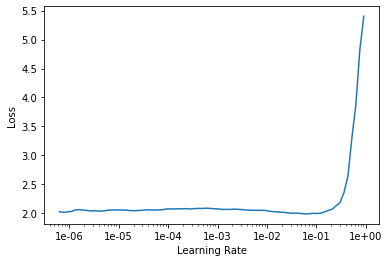

In [12]:
ln.recorder.plot()